# ADS 505 - Applied Data Science for Business, Module 3, Assignment 1
Sasha Libolt

## Library & Data imports

In [4]:
#library imports
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix,  roc_curve
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import SVC

import matplotlib.pylab as plt
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
%matplotlib inline


import seaborn as sns


from mlxtend.feature_selection import SequentialFeatureSelector


# Ignore SettingWithCopyWarning only
import warnings
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

In [5]:
#data import
df = pd.read_csv("C:/Users/sasha/OneDrive - University of San Diego/ADS 505 - Applied Data Science for Business/M3/taxi.csv")
df.head()

,row#,user_id,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,from_date,to_date,online_booking,mobile_site_booking,booking_created,from_lat,from_long,to_lat,to_long,Car_Cancellation
0,1,17712,12,NaN,2,1021.0,1323.0,NaN,NaN,1/1/13 22:33,NaN,0,0,1/1/13 8:01,13.028530,77.54625,12.869805,77.653211,0
1,2,17037,12,NaN,2,455.0,1330.0,NaN,NaN,1/1/13 12:43,NaN,0,0,1/1/13 9:59,12.999874,77.67812,12.953434,77.706510,0
2,3,761,12,NaN,2,814.0,393.0,NaN,NaN,1/2/13 0:28,1/3/13 0:00,1,0,1/1/13 12:14,12.908993,77.68890,13.199560,77.706880,0
3,4,868,12,NaN,2,297.0,212.0,NaN,NaN,1/1/13 13:12,NaN,0,0,1/1/13 12:42,12.997890,77.61488,12.994740,77.607970,0
4,5,21716,28,NaN,2,1237.0,330.0,NaN,NaN,1/1/13 16:33,NaN,0,0,1/1/13 15:07,12.926450,77.61206,12.858833,77.589127,0


## Question 1: How can a predictive model based on these data be used by Yourcabs.com?

A predictive model can help Yourcabs isolate the factors that are causing driver cancellations. If the company is able to accurately make a prediction as to a ride that is likely to be cancelled by a driver, they can send out a backup driver so customers are not left hanging.  Additionally, by understanding the predictors that influence car cancellation, they can optimize driver scheduleling and ensure they have the right periods or locations staffed to prevent cancellations.

## Question 2: How can a profiling model (identifying predictors that distinguish canceled/uncanceled trips) be used by Yourcabs.com?

Yourcabs can investigate the why behind the predictors in order to research and create new policies that would mitigate the risk. For example, if there is high predictive power as to where the booking was made, perhaps there is an issue with the transfer of information to the drivers. This could lead to a fix in the technology or the workflow, for example an extra confirmation feature on the driver's side. These predictors can prompt internal company investigation either proactively fix workflow issues or create policies that mitigate risk.

## Question 3: Explore, prepare, and transform the data to facilitate predictive modeling. Here are some hints: 
- 3.1 In exploratory modeling, it is useful to move fairly soon to at least an initial model without solving all data preparation issues. One example is the GPS information—other geographic information is available so you could defer the challenge of how to interpret/use the GPS information.
- 3.2 How will you deal with missing data, such as cases where NaN is indicated?
- 3.3 Think about what useful information might be held within the date and time fields (the booking timestamp and the trip timestamp).
- 3.4 Think also about the categorical variables, and how to deal with them. Should we turn them all into dummies? Use only some?


### Data Overview

In [12]:
#check for data rows & columns
df.shape


(10000, 19)

In [13]:
#get all column names & data types
df.dtypes

row#                     int64
user_id                  int64
vehicle_model_id         int64
package_id             float64
travel_type_id           int64
from_area_id           float64
to_area_id             float64
from_city_id           float64
to_city_id             float64
from_date               object
to_date                 object
online_booking           int64
mobile_site_booking      int64
booking_created         object
from_lat               float64
from_long              float64
to_lat                 float64
to_long                float64
Car_Cancellation         int64
dtype: object

In [14]:
#why is booking_created an object?

df['booking_created'].value_counts()       

booking_created
9/27/13 14:33    7
10/31/13 9:58    6
10/9/13 10:07    6
8/1/13 7:24      6
9/30/13 10:38    5
                ..
5/23/13 13:22    1
5/23/13 14:04    1
5/23/13 14:16    1
5/23/13 14:59    1
1/12/13 18:41    1
Name: count, Length: 9611, dtype: int64

Note: date fields (from_date, to_date, booking_created) are objects. Will consider converting them to datetime at a later step. Additionally, some of the _id_ columns are float64. This could be because  null values are present. Will convert to int64 at a later step.

In [16]:
#check for duplicate rows
df.duplicated().sum()

0

In [17]:
#is there class imbalance? 
df['Car_Cancellation'].value_counts()

Car_Cancellation
0    9257
1     743
Name: count, dtype: int64

In [18]:
print("percentage of each class", df['Car_Cancellation'].value_counts()/len(df)*100)

percentage of each class Car_Cancellation
0    92.57
1     7.43
Name: count, dtype: float64


Note: Class imbalance is present. Only 7% of data is positive. Will need to keep this in mind when splitting data

### Data Quality Report - Continuous

In [21]:
# identify continuous features
conf = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
conf

['row#',
 'user_id',
 'vehicle_model_id',
 'package_id',
 'travel_type_id',
 'from_area_id',
 'to_area_id',
 'from_city_id',
 'to_city_id',
 'online_booking',
 'mobile_site_booking',
 'from_lat',
 'from_long',
 'to_lat',
 'to_long',
 'Car_Cancellation']

In [22]:
#identify any columns to filter out from the "continuous features"
conf_exclude = ['row#'] #excluding row# as that is just an id for the row
filter_conf = [x for x in conf if x not in conf_exclude]
filter_conf

['user_id',
 'vehicle_model_id',
 'package_id',
 'travel_type_id',
 'from_area_id',
 'to_area_id',
 'from_city_id',
 'to_city_id',
 'online_booking',
 'mobile_site_booking',
 'from_lat',
 'from_long',
 'to_lat',
 'to_long',
 'Car_Cancellation']

In [23]:
pd.options.display.float_format = '{:.3f}'.format #ensures that the formatting will be more readable.

data_quality_conf = pd.DataFrame({
    'Feature': filter_conf,
    'Count': df[filter_conf].count().values,
    'Missing Values': df[filter_conf].isnull().sum().values,
    'Cardinality': df[filter_conf].nunique().values,
    'Min': df[filter_conf].min().values,
    '1st Quartile': df[filter_conf].quantile(0.25).values,
    'Mean': df[filter_conf].mean().values,
    'Median': df[filter_conf].median().values,
    '3rd Quartile': df[filter_conf].quantile(0.75).values,
    'Max': df[filter_conf].max().values,
    'Standard Deviation': df[filter_conf].std().values,
})
print("Data Quality Report, Continuous Features")
data_quality_conf

Data Quality Report, Continuous Features


,Feature,Count,Missing Values,Cardinality,Min,1st Quartile,Mean,Median,3rd Quartile,Max,Standard Deviation
0,user_id,10000,0,7044,16.000,24410.750,30663.966,31510.000,39094.500,48729.000,10988.600
1,vehicle_model_id,10000,0,20,1.000,12.000,26.192,12.000,24.000,91.000,27.228
2,package_id,1752,8248,7,1.000,1.000,1.988,2.000,2.000,7.000,1.402
3,travel_type_id,10000,0,3,1.000,2.000,2.141,2.000,2.000,3.000,0.435
4,from_area_id,9985,15,522,2.000,393.000,709.768,590.000,1086.000,1401.000,418.969
5,to_area_id,7909,2091,479,6.000,393.000,665.458,516.000,1052.000,1403.000,400.629
6,from_city_id,3706,6294,2,1.000,15.000,14.898,15.000,15.000,15.000,1.191
7,to_city_id,339,9661,67,4.000,32.000,68.319,49.000,108.000,203.000,49.886
8,online_booking,10000,0,2,0.000,0.000,0.353,0.000,1.000,1.000,0.478
9,mobile_site_booking,10000,0,2,0.000,0.000,0.042,0.000,0.000,1.000,0.202


#### Data Quality Report - Continuous Observations
##### Missing Data
- The following columns have more than 62% missing data: package_id, from_city_id, to_city_id, 
- The following columns have around 20% missing: to_area_id, to_lat, to_long
- The following columns have 0.15% missing: from_long, from_lat, from_area_id
#### High Standard Deviations
- As expected, user_id has a high standard deviation, this is because you would expect that it would be unique. There are some repeat customers indicated by the cardinality not being equal to size of dataset. 
- The following columns have high standard deviations that may need investigation: from_area_id, to_area_id

### Data Quality Report - Categorical

In [26]:
#identify any categorical features
catf = df.select_dtypes(include=['object']).columns.tolist()
catf

['from_date', 'to_date', 'booking_created']

In [27]:
#create lists to store modes & frequencies
modes = []
mode_freqs = []
second_modes = []
second_mode_freqs = []
mode_percentages = []
second_mode_percentages = []

In [28]:
# Calculate mode and frequency for each categorical feature
for feature in catf:
    count = df[feature].count()
    mode = df[feature].mode().iloc[0]
    mode_freq = df[feature].value_counts().iloc[0]
    modes.append(mode)
    mode_freqs.append(mode_freq)
    mode_percentages.append((mode_freq / count) * 100 if count > 0 else 0)

    # Calculate second mode and its frequency
    if len(df[feature].value_counts()) > 1:
        second_mode = df[feature].value_counts().index[1]
        second_mode_freq = df[feature].value_counts().iloc[1]
    else:
        second_mode = None
        second_mode_freq = 0

    second_modes.append(second_mode)
    second_mode_freqs.append(second_mode_freq)
    second_mode_percentages.append((second_mode_freq / count) * 100 if count > 0 else 0)

In [29]:
#build quality report table
data_quality_catf = pd.DataFrame({
    'Feature': catf,
    'Count': df[catf].count().values,
    'Missing Values': df[catf].isnull().sum().values,
    'Cardinality': df[catf].nunique().values,
    'Mode':modes,
    'Mode Frequency':mode_freqs,
    'Mode %': mode_percentages,
    '2nd Mode':second_modes,
    '2nd Mode Frequency': second_mode_freqs,
    '2nd Mode %': second_mode_percentages,
})
data_quality_catf

,Feature,Count,Missing Values,Cardinality,Mode,Mode Frequency,Mode %,2nd Mode,2nd Mode Frequency,2nd Mode %
0,from_date,10000,0,7976,7/4/13 22:19,6,0.060,7/4/13 22:19,6,0.060
1,to_date,5822,4178,5332,5/12/13 0:00,13,0.223,6/2/13 0:00,12,0.206
2,booking_created,10000,0,9611,9/27/13 14:33,7,0.070,10/31/13 9:58,6,0.060


#### Data Quality Report - Categorical Observations
##### Missing Data
- to_date is missing 41% of data.
- all the categorical information is the date fields as theya re stored as objects.

### Handling Null Values

In [32]:
#how many rows have a null value? Source = https://stackoverflow.com/questions/30447083/python-pandas-return-only-those-rows-which-have-missing-values
sum(df.isnull().any(axis=1))
#answer:  all rows impacted. 

10000

In [33]:
null_count = df.isna().sum()
null_percent = (null_count/10000)*100
data_type = df.dtypes
nulls_df = pd.DataFrame({
    'Total Nulls': null_count, 
    'Percent Null': null_percent, 
    'Data Type': data_type
})
nulls_df =  nulls_df.sort_values(by='Percent Null', ascending = False)
display(nulls_df)

,Total Nulls,Percent Null,Data Type
to_city_id,9661,96.610,float64
package_id,8248,82.480,float64
from_city_id,6294,62.940,float64
to_date,4178,41.780,object
to_long,2091,20.910,float64
to_lat,2091,20.910,float64
to_area_id,2091,20.910,float64
from_area_id,15,0.150,float64
from_long,15,0.150,float64
from_lat,15,0.150,float64


In [34]:
df.head()

,row#,user_id,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,from_date,to_date,online_booking,mobile_site_booking,booking_created,from_lat,from_long,to_lat,to_long,Car_Cancellation
0,1,17712,12,NaN,2,1021.000,1323.000,NaN,NaN,1/1/13 22:33,NaN,0,0,1/1/13 8:01,13.029,77.546,12.870,77.653,0
1,2,17037,12,NaN,2,455.000,1330.000,NaN,NaN,1/1/13 12:43,NaN,0,0,1/1/13 9:59,13.000,77.678,12.953,77.707,0
2,3,761,12,NaN,2,814.000,393.000,NaN,NaN,1/2/13 0:28,1/3/13 0:00,1,0,1/1/13 12:14,12.909,77.689,13.200,77.707,0
3,4,868,12,NaN,2,297.000,212.000,NaN,NaN,1/1/13 13:12,NaN,0,0,1/1/13 12:42,12.998,77.615,12.995,77.608,0
4,5,21716,28,NaN,2,1237.000,330.000,NaN,NaN,1/1/13 16:33,NaN,0,0,1/1/13 15:07,12.926,77.612,12.859,77.589,0


In [35]:
#get a list of all the null features + target variable: 
null_features = ['to_city_id', 'package_id', 'from_city_id', 'to_date', 'to_long', 'to_lat', 'to_area_id', 'from_area_id', 'from_long', 'from_lat', 'Car_Cancellation']
#to_date is an object, will need to be converted to work:
df['to_date'] = pd.to_datetime(df['to_date'], format='%m/%d/%y %H:%M')
corr_matrix = df[null_features].corr()
#narrow down what is correlated to target variable
target_column = 'Car_Cancellation'
corr_with_target = corr_matrix[target_column].abs()
print(corr_with_target)

to_city_id         0.062
package_id         0.093
from_city_id       0.029
to_date            0.055
to_long            0.106
to_lat             0.116
to_area_id         0.073
from_area_id       0.017
from_long          0.043
from_lat           0.083
Car_Cancellation   1.000
Name: Car_Cancellation, dtype: float64


#### Decisions
- None of the features that are missing information display a strong (.7+) relation or even a moderate (.4+) relationship. 
- The following features will be removed entirely as 20% or more of their data is missing from the dataset and there is not a significant relationship: to_city_id, package_id, from_city_id, to_long, to_lat, to_area_id

In [37]:
columns_to_drop = ['row#','to_city_id', 'package_id', 'from_city_id', 'to_date','to_lat', 'to_long', 'to_area_id'] #dropping all columns that didn't meet threshold, + row# as it is just an ID
df_dropped_features= df.drop(columns = columns_to_drop, axis = 1)
df_dropped_features.shape #confirm columns dropped

(10000, 11)

In [38]:
#confirm if it is still 15 missing from from_area_id, _from_lat, & from_long.
df_dropped_features.isna().sum()

user_id                 0
vehicle_model_id        0
travel_type_id          0
from_area_id           15
from_date               0
online_booking          0
mobile_site_booking     0
booking_created         0
from_lat               15
from_long              15
Car_Cancellation        0
dtype: int64

In [39]:
#The maximum impact of dropping all nulls is 45 rows. This would assume that each of the nulls in the columns above are in a unique row and no row has multiple featueres missing. 
# as a result, our max impact of dropping all nulls would be 45/10,000 = .0045, or .5 %. Thus drop all rows. 
df_dropped_rows = df_dropped_features.dropna()
df_dropped_rows.shape
print(f"The original dataset shape was: {df.shape}.")
print(f"Next, we dropped columns with more than 20% null values and the new shape was: {df_dropped_features.shape}.")
print(f"Finally, we dropped any row with a null value. The final dataset shape is: {df_dropped_rows.shape}")

The original dataset shape was: (10000, 19).
Next, we dropped columns with more than 20% null values and the new shape was: (10000, 11).
Finally, we dropped any row with a null value. The final dataset shape is: (9985, 11)


### Prepare Dataframe for Modeling

#### Address the data column type

In [42]:
df_dropped_rows.dtypes

user_id                  int64
vehicle_model_id         int64
travel_type_id           int64
from_area_id           float64
from_date               object
online_booking           int64
mobile_site_booking      int64
booking_created         object
from_lat               float64
from_long              float64
Car_Cancellation         int64
dtype: object

In [43]:
df_dropped_rows.head()

,user_id,vehicle_model_id,travel_type_id,from_area_id,from_date,online_booking,mobile_site_booking,booking_created,from_lat,from_long,Car_Cancellation
0,17712,12,2,1021.000,1/1/13 22:33,0,0,1/1/13 8:01,13.029,77.546,0
1,17037,12,2,455.000,1/1/13 12:43,0,0,1/1/13 9:59,13.000,77.678,0
2,761,12,2,814.000,1/2/13 0:28,1,0,1/1/13 12:14,12.909,77.689,0
3,868,12,2,297.000,1/1/13 13:12,0,0,1/1/13 12:42,12.998,77.615,0
4,21716,28,2,1237.000,1/1/13 16:33,0,0,1/1/13 15:07,12.926,77.612,0


In [44]:
df_dropped_rows['from_date'] = pd.to_datetime(df_dropped_rows['from_date'], format='%m/%d/%y %H:%M')
df_dropped_rows['booking_created'] = pd.to_datetime(df_dropped_rows['booking_created'], format='%m/%d/%y %H:%M')
df_dropped_rows.dtypes

user_id                         int64
vehicle_model_id                int64
travel_type_id                  int64
from_area_id                  float64
from_date              datetime64[ns]
online_booking                  int64
mobile_site_booking             int64
booking_created        datetime64[ns]
from_lat                      float64
from_long                     float64
Car_Cancellation                int64
dtype: object

In [45]:
#generate a final data quality report. 
pd.options.display.float_format = '{:.3f}'.format 
data_quality_dropped = pd.DataFrame({
    'Feature': df_dropped_rows.columns,
    'Count': df_dropped_rows.count().values,
    'Missing Values': df_dropped_rows.isnull().sum().values,
    'Cardinality': df_dropped_rows.nunique().values,
    'Min': df_dropped_rows.min().values,
    '1st Quartile': df_dropped_rows.quantile(0.25).values,
    'Mean': df_dropped_rows.mean().values,
    'Median': df_dropped_rows.median().values,
    '3rd Quartile': df_dropped_rows.quantile(0.75).values,
    'Max': df_dropped_rows.max().values,
    'Standard Deviation': df_dropped_rows.std().values,
})
display(data_quality_dropped)

,Feature,Count,Missing Values,Cardinality,Min,1st Quartile,Mean,Median,3rd Quartile,Max,Standard Deviation
0,user_id,9985,0,7032,16,24399.000,30656.544,31500.000,39082.000,48729,10991.151
1,vehicle_model_id,9985,0,18,1,12.000,26.174,12.000,24.000,91,27.228
2,travel_type_id,9985,0,3,1,2.000,2.143,2.000,2.000,3,0.433
3,from_area_id,9985,0,522,2.000,393.000,709.768,590.000,1086.000,1401.000,418.969
4,from_date,9985,0,7967,2013-01-01 03:36:00,2013-04-22 18:28:00,2013-06-29 15:32:35.585378048,2013-07-08 04:04:00,2013-09-10 18:43:00,2013-12-15 04:33:00,90 days 00:36:36.921117043
5,online_booking,9985,0,2,0,0.000,0.353,0.000,1.000,1,0.478
6,mobile_site_booking,9985,0,2,0,0.000,0.042,0.000,0.000,1,0.202
7,booking_created,9985,0,9596,2013-01-01 03:08:00,2013-04-21 21:23:00,2013-06-28 03:46:00.751126784,2013-07-06 11:41:00,2013-09-08 10:24:00,2013-11-24 14:35:00,89 days 09:30:58.956109963
8,from_lat,9985,0,422,12.777,12.927,12.983,12.969,13.006,13.366,0.086
9,from_long,9985,0,419,77.387,77.595,77.636,77.636,77.688,77.786,0.059


#### Feature Engineering

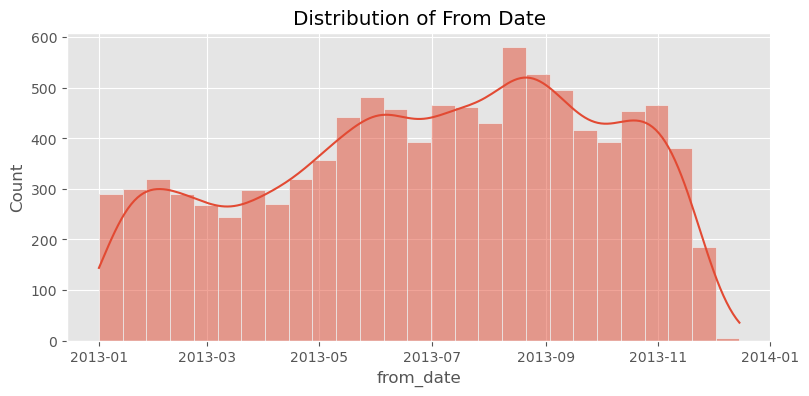

In [47]:
#investigate distribution of "From Date"
plt.style.use('ggplot')
plt.figure(figsize=(20, 4))
plt.subplot(1, 2, 1)
sns.histplot(df_dropped_rows['from_date'], kde = True)
plt.title(f'Distribution of From Date')
plt.show()

Most of the data is in the same year, 2013. Will add a column for "day of the week" and for month.

In [49]:
#create new fields for from_date day & month
df_dropped_rows['from_date_day'] = df_dropped_rows['from_date'].dt.day_name()
df_dropped_rows['from_date_month'] = df_dropped_rows['from_date'].dt.month_name()
df_dropped_rows.head()

,user_id,vehicle_model_id,travel_type_id,from_area_id,from_date,online_booking,mobile_site_booking,booking_created,from_lat,from_long,Car_Cancellation,from_date_day,from_date_month
0,17712,12,2,1021.000,2013-01-01 22:33:00,0,0,2013-01-01 08:01:00,13.029,77.546,0,Tuesday,January
1,17037,12,2,455.000,2013-01-01 12:43:00,0,0,2013-01-01 09:59:00,13.000,77.678,0,Tuesday,January
2,761,12,2,814.000,2013-01-02 00:28:00,1,0,2013-01-01 12:14:00,12.909,77.689,0,Wednesday,January
3,868,12,2,297.000,2013-01-01 13:12:00,0,0,2013-01-01 12:42:00,12.998,77.615,0,Tuesday,January
4,21716,28,2,1237.000,2013-01-01 16:33:00,0,0,2013-01-01 15:07:00,12.926,77.612,0,Tuesday,January


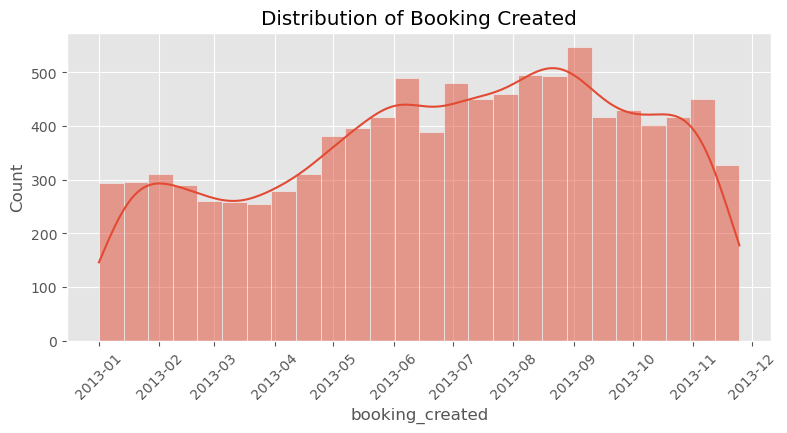

In [50]:
#investigate distribution of "From Date"
plt.style.use('ggplot')
plt.figure(figsize=(20, 4))
plt.subplot(1, 2, 1)
sns.histplot(df_dropped_rows['booking_created'], kde=True)
plt.title('Distribution of Booking Created')
# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45)
plt.show()

In [51]:
#create new fields for booking_created day & month
df_dropped_rows['booking_created_day'] = df_dropped_rows['booking_created'].dt.day_name()
df_dropped_rows['booking_created_month'] = df_dropped_rows['booking_created'].dt.month_name()
df_dropped_rows.head()

,user_id,vehicle_model_id,travel_type_id,from_area_id,from_date,online_booking,mobile_site_booking,booking_created,from_lat,from_long,Car_Cancellation,from_date_day,from_date_month,booking_created_day,booking_created_month
0,17712,12,2,1021.000,2013-01-01 22:33:00,0,0,2013-01-01 08:01:00,13.029,77.546,0,Tuesday,January,Tuesday,January
1,17037,12,2,455.000,2013-01-01 12:43:00,0,0,2013-01-01 09:59:00,13.000,77.678,0,Tuesday,January,Tuesday,January
2,761,12,2,814.000,2013-01-02 00:28:00,1,0,2013-01-01 12:14:00,12.909,77.689,0,Wednesday,January,Tuesday,January
3,868,12,2,297.000,2013-01-01 13:12:00,0,0,2013-01-01 12:42:00,12.998,77.615,0,Tuesday,January,Tuesday,January
4,21716,28,2,1237.000,2013-01-01 16:33:00,0,0,2013-01-01 15:07:00,12.926,77.612,0,Tuesday,January,Tuesday,January


In [52]:
df_dropped_rows.dtypes

user_id                           int64
vehicle_model_id                  int64
travel_type_id                    int64
from_area_id                    float64
from_date                datetime64[ns]
online_booking                    int64
mobile_site_booking               int64
booking_created          datetime64[ns]
from_lat                        float64
from_long                       float64
Car_Cancellation                  int64
from_date_day                    object
from_date_month                  object
booking_created_day              object
booking_created_month            object
dtype: object

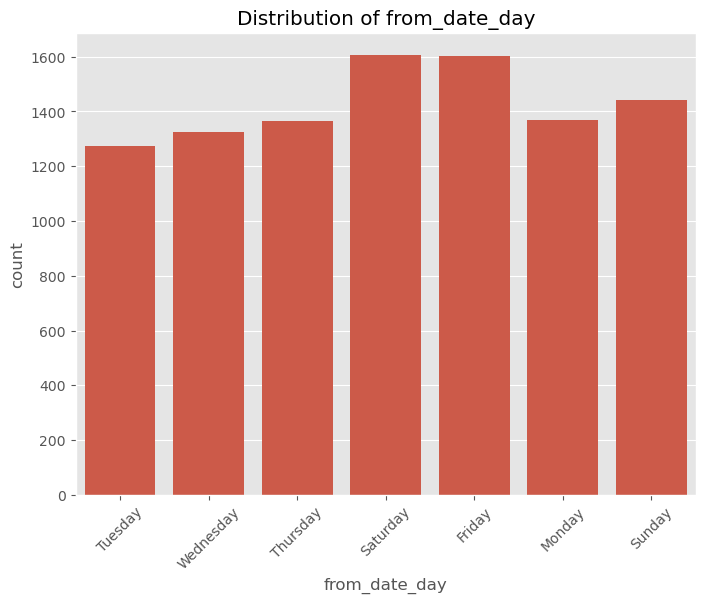

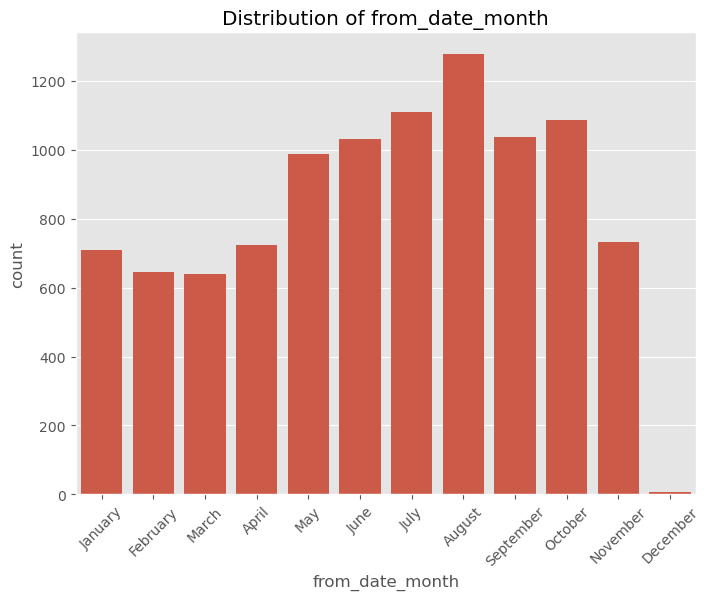

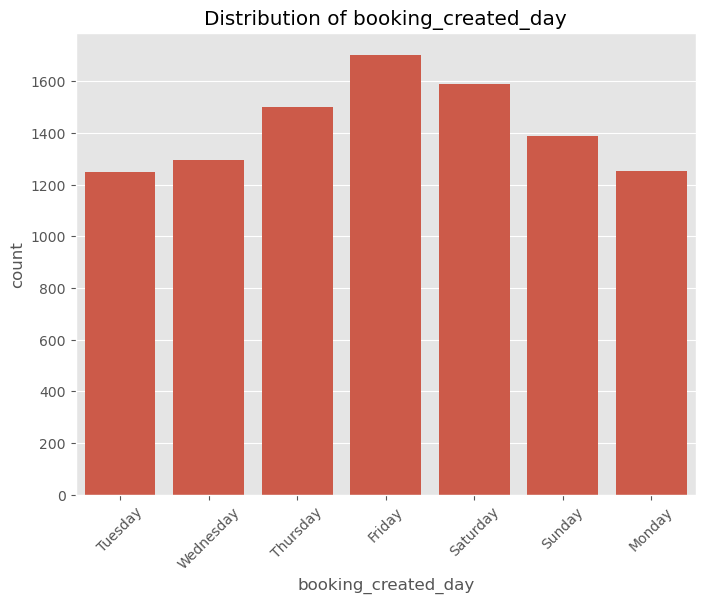

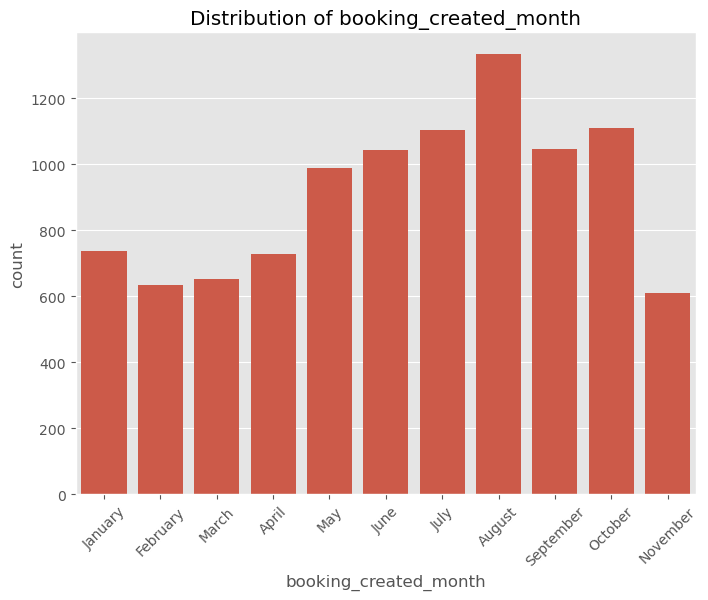

In [53]:
#plot the new "booking created day/month" and "from day/month"

features_to_plot = ['from_date_day', 'from_date_month', 'booking_created_day', 'booking_created_month']                   

plt.style.use('ggplot')

for column in features_to_plot:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=column, data=df_dropped_rows)
    plt.title(f'Distribution of {column}')
    plt.xticks(rotation=45)
    plt.show()

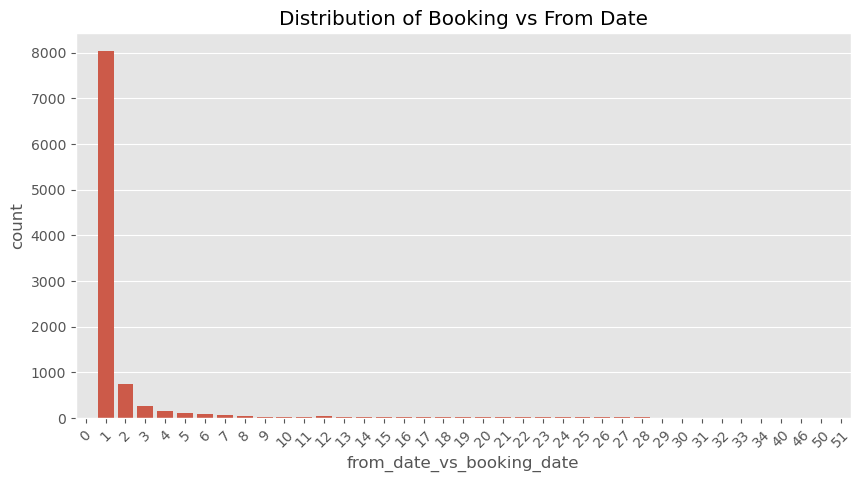

In [54]:
# Subtract the two date columns and round up to the nearest full day
df_dropped_rows['from_date_vs_booking_date'] = (df_dropped_rows['from_date'] - df_dropped_rows['booking_created']).dt.ceil('D')

# Extract only the number of days
df_dropped_rows['from_date_vs_booking_date'] = df_dropped_rows['from_date_vs_booking_date'].dt.days

#plot the distribution
plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
sns.countplot(x='from_date_vs_booking_date', data=df_dropped_rows)
plt.title(f'Distribution of Booking vs From Date')
plt.xticks(rotation=45)
plt.show()

In [55]:
df_dropped_rows.dtypes

user_id                               int64
vehicle_model_id                      int64
travel_type_id                        int64
from_area_id                        float64
from_date                    datetime64[ns]
online_booking                        int64
mobile_site_booking                   int64
booking_created              datetime64[ns]
from_lat                            float64
from_long                           float64
Car_Cancellation                      int64
from_date_day                        object
from_date_month                      object
booking_created_day                  object
booking_created_month                object
from_date_vs_booking_date             int64
dtype: object

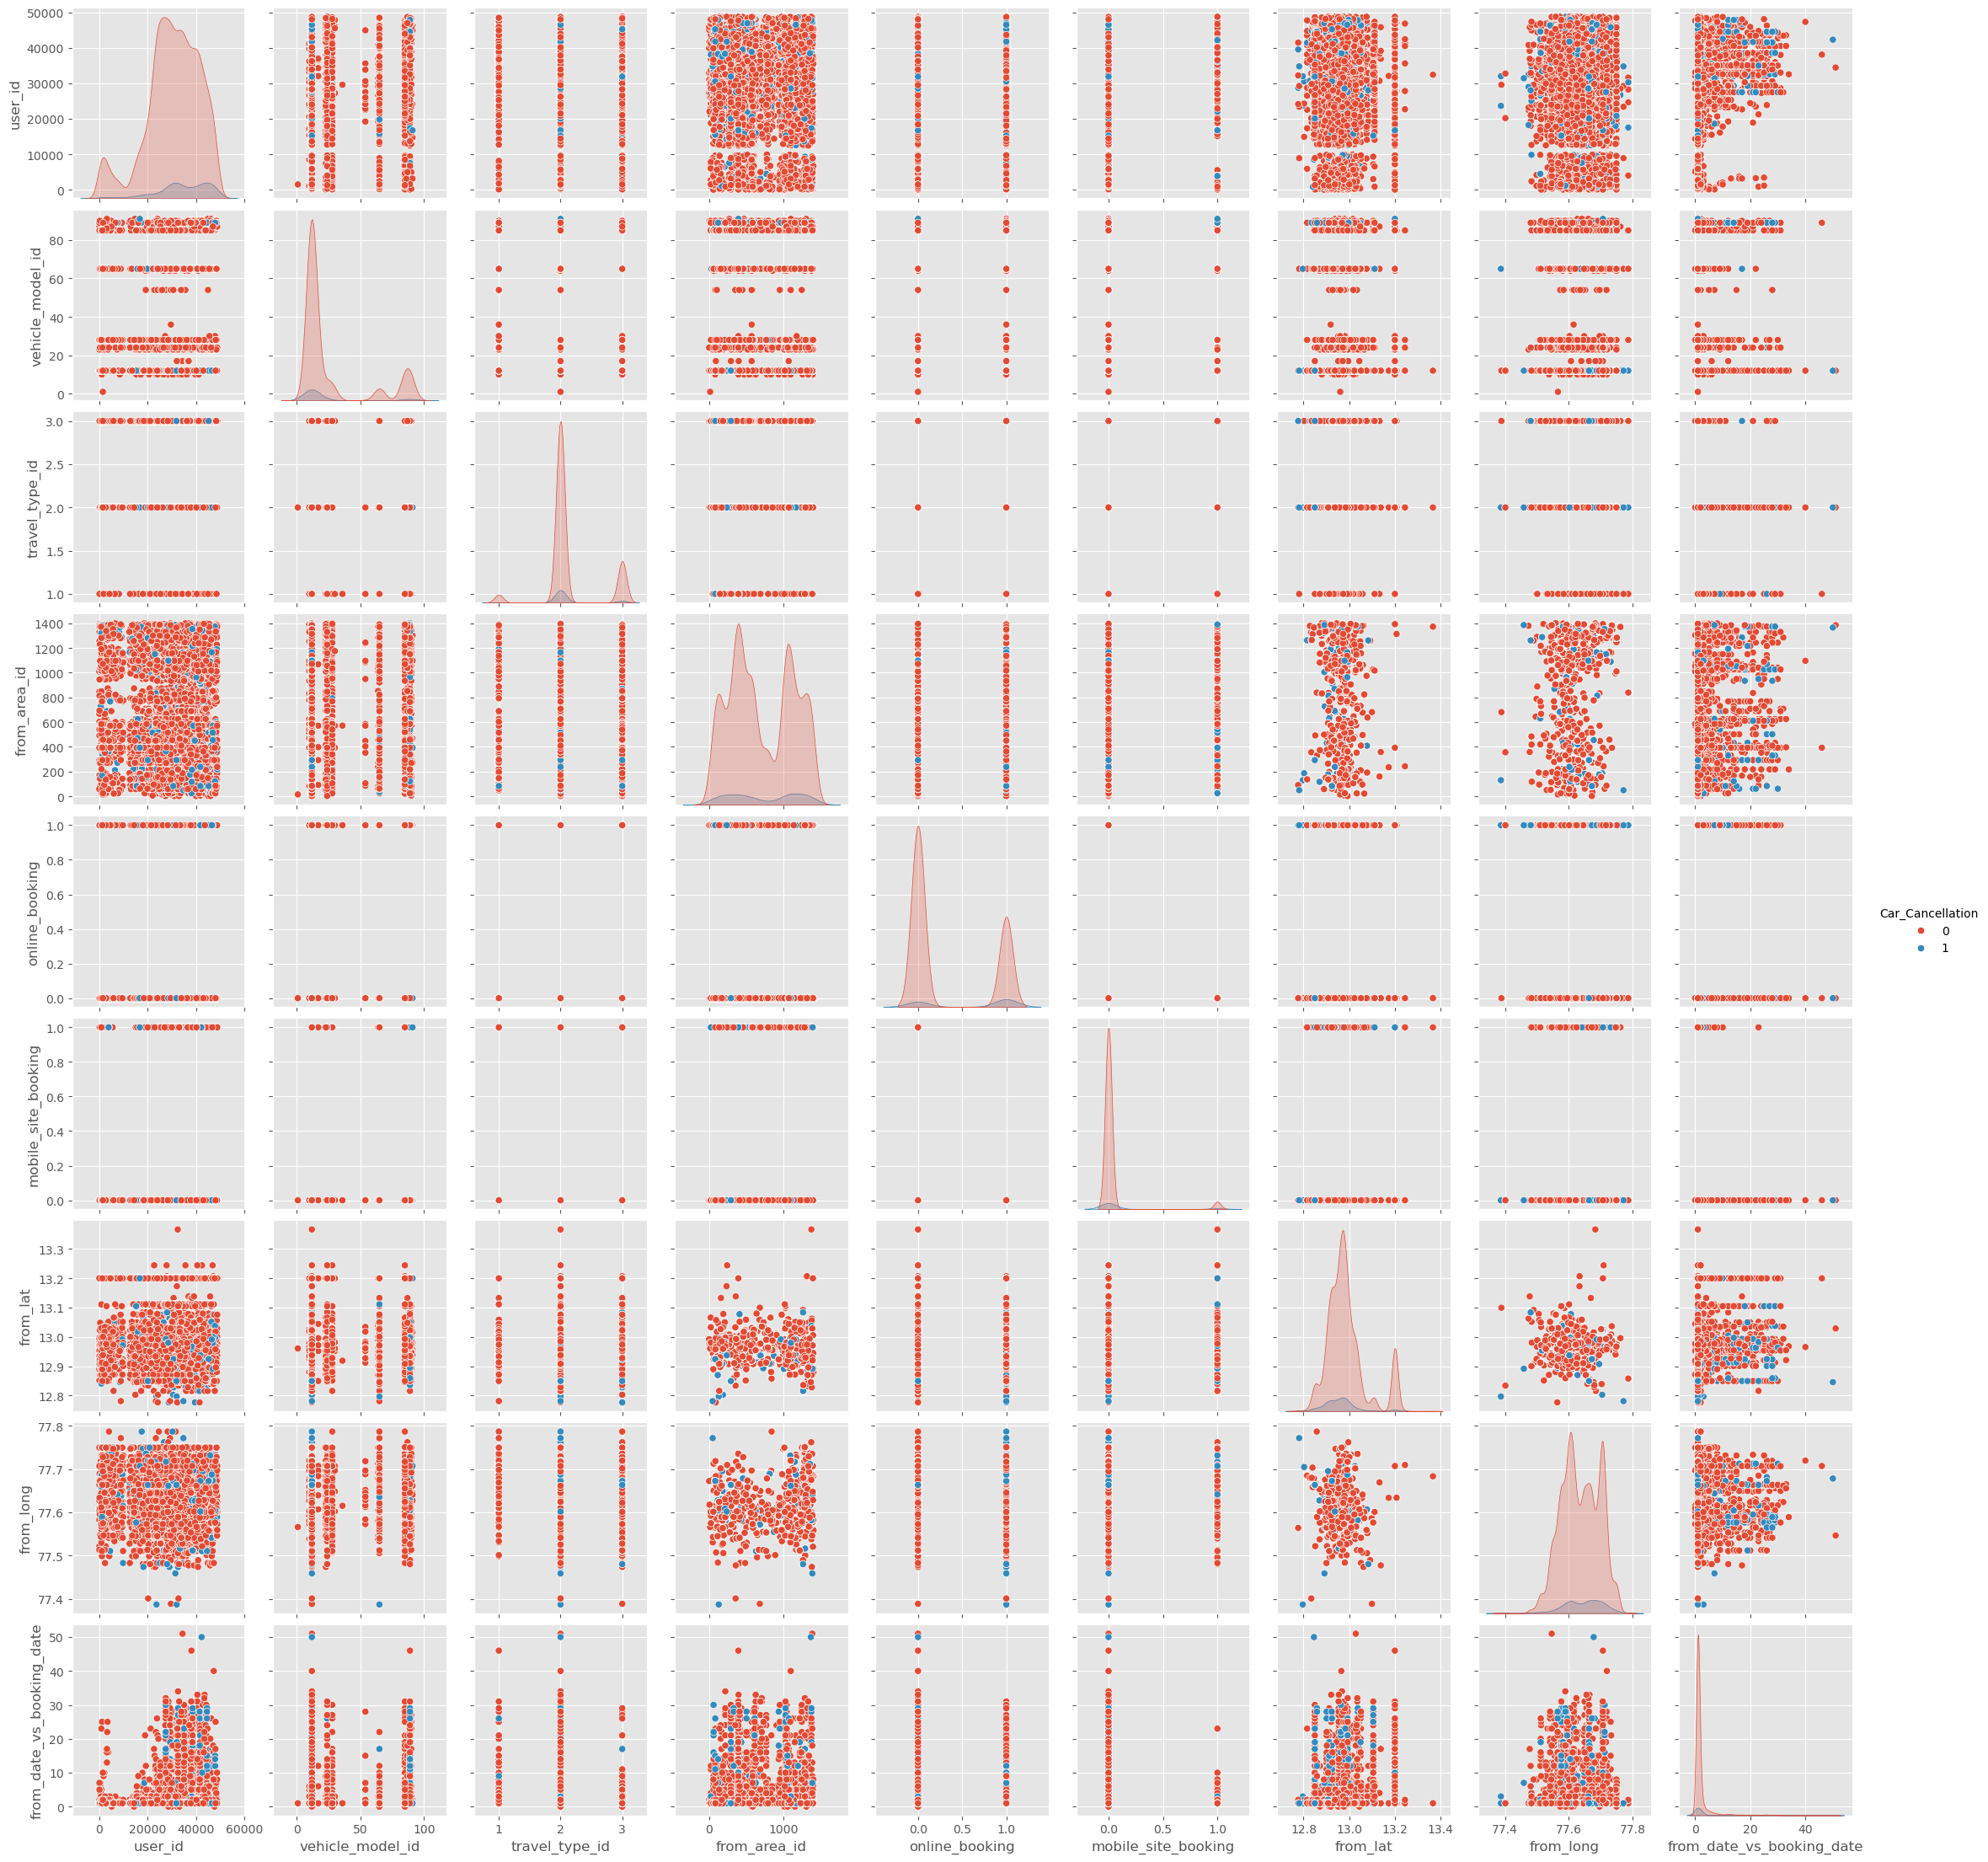

In [56]:
continuous_features = df_dropped_rows.select_dtypes(include=['float64', 'int64']).columns.tolist()
sns.pairplot(df_dropped_rows[continuous_features], hue = 'Car_Cancellation')

A visual inspection seems to indicate there isn't a strong correlation among most of of the features. I will go ahead and group booking vs from days into the following categories to see if this will be more useful when doing our modeling: 
- Same Day (0-1 days)
- Same Week (2-7 days)
- Advanced (8+ days)

Additionally will group times into the following categories: 
- Morning (5 AM - 11:59 AM)
- Afternoon (12 PM - 4:59 PM)
- Evening (5PM - 8:59 PM)
- Night : 9 PM +

In [58]:
#going to put the booking dates in categories 
def categorize_days(days):
    if days <= 1:
        return 'Same Day'
    elif 2 <= days <= 7:
        return 'Same Week'
    else:
        return 'Advanced'

# Apply the function to create the new column
df_dropped_rows['booking_date_category'] = df_dropped_rows['from_date_vs_booking_date'].apply(categorize_days)

df_dropped_rows['booking_date_category'].value_counts()


def categorize_time(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

# Extract the hour from each column and categorize
df_dropped_rows['from_time_category'] = df_dropped_rows['from_date'].dt.hour.apply(categorize_time)
df_dropped_rows['booking_time_category'] = df_dropped_rows['booking_created'].dt.hour.apply(categorize_time)
# Check the count of each category
df_dropped_rows['booking_time_category'].value_counts()

booking_time_category
Afternoon    2948
Morning      2718
Evening      2442
Night        1877
Name: count, dtype: int64

In [59]:
df_dropped_rows['from_time_category'].value_counts()

from_time_category
Morning      3837
Night        2169
Evening      2011
Afternoon    1968
Name: count, dtype: int64

In [103]:
# get a data quality report of my new categorical features
cat_features = df_dropped_rows.select_dtypes(include=['object']).columns.tolist()
#create lists to store modes & frequencies
modes2 = []
mode_freqs2 = []
second_modes2 = []
second_mode_freqs2 = []
mode_percentages2 = []
second_mode_percentages2 = []


# Calculate mode and frequency for each categorical feature
for feature in cat_features:
    count = df_dropped_rows[feature].count()
    mode2 = df_dropped_rows[feature].mode().iloc[0]
    mode_freq2 = df_dropped_rows[feature].value_counts().iloc[0]
    modes2.append(mode2)
    mode_freqs2.append(mode_freq2)
    mode_percentages2.append((mode_freq2 / count) * 100 if count > 0 else 0)

    # Calculate second mode and its frequency
    if len(df_dropped_rows[feature].value_counts()) > 1:
        second_mode2 = df_dropped_rows[feature].value_counts().index[1]
        second_mode_freq2 = df_dropped_rows[feature].value_counts().iloc[1]
    else:
        second_mode2 = None
        second_mode_freq2 = 0

    second_modes2.append(second_mode2)
    second_mode_freqs2.append(second_mode_freq2)
    second_mode_percentages2.append((second_mode_freq2 / count) * 100 if count > 0 else 0)

    
#build quality report table
data_quality_newcat = pd.DataFrame({
    'Feature': cat_features,
    'Count': df_dropped_rows[cat_features].count().values,
    'Missing Values': df_dropped_rows[cat_features].isnull().sum().values,
    'Cardinality': df_dropped_rows[cat_features].nunique().values,
    'Mode':modes2,
    'Mode Frequency':mode_freqs2,
    'Mode %': mode_percentages2,
    '2nd Mode':second_modes2,
    '2nd Mode Frequency': second_mode_freqs2,
    '2nd Mode %': second_mode_percentages2,
})
data_quality_newcat


,Feature,Count,Missing Values,Cardinality,Mode,Mode Frequency,Mode %,2nd Mode,2nd Mode Frequency,2nd Mode %
0,from_date_day,9985,0,7,Saturday,1607,16.094,Friday,1604,16.064
1,from_date_month,9985,0,12,August,1277,12.789,July,1109,11.107
2,booking_created_day,9985,0,7,Friday,1703,17.056,Saturday,1591,15.934
3,booking_created_month,9985,0,11,August,1333,13.350,October,1110,11.117
4,booking_date_category,9985,0,3,Same Day,8033,80.451,Same Week,1443,14.452
5,from_time_category,9985,0,4,Morning,3837,38.428,Night,2169,21.723
6,booking_time_category,9985,0,4,Afternoon,2948,29.524,Morning,2718,27.221


## Question 4: Fit several predictive models of your choice. Do they provide information on how the predictor variables relate to cancellations?

### Prep Dataset

In [105]:
#one-hot encode variables
df_encoded = pd.get_dummies(df_dropped_rows, columns = cat_features, drop_first = True)
#dropping dates for model
df_encoded_to_drop = ['from_date', 'booking_created'] 
df_encoded = df_encoded.drop(columns = df_encoded_to_drop, axis =1)

In [107]:
df_encoded.shape

(9985, 51)

In [109]:
df_encoded.dtypes

user_id                              int64
vehicle_model_id                     int64
travel_type_id                       int64
from_area_id                       float64
online_booking                       int64
mobile_site_booking                  int64
from_lat                           float64
from_long                          float64
Car_Cancellation                     int64
from_date_vs_booking_date            int64
from_date_day_Monday                  bool
from_date_day_Saturday                bool
from_date_day_Sunday                  bool
from_date_day_Thursday                bool
from_date_day_Tuesday                 bool
from_date_day_Wednesday               bool
from_date_month_August                bool
from_date_month_December              bool
from_date_month_February              bool
from_date_month_January               bool
from_date_month_July                  bool
from_date_month_June                  bool
from_date_month_March                 bool
from_date_m

In [111]:
# Split the data (stratified to account for class imbalance), 80/20 split per Pareto principle
X = df_encoded.drop('Car_Cancellation', axis=1)
y = df_encoded['Car_Cancellation']
X_train0, X_test0, y_train0, y_test0 = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# scale data
scaler = StandardScaler()
X_train_scaled0 = scaler.fit_transform(X_train0)
X_test_scaled0 = scaler.transform(X_test0)

### Feature Selection using Random Forest Feature Importances

In [125]:
#Use Random Forest to also help us discover the feature importances. 
#Full tutorial: https://www.geeksforgeeks.org/feature-selection-in-python-with-scikit-learn/

from sklearn.ensemble import RandomForestClassifier

# Train random forest and get feature importances
forest_baseline = RandomForestClassifier()
forest_baseline.fit(X_train_scaled0, y_train0)
importances = forest_baseline.feature_importances_

# Display feature importances
feature_importances = pd.Series(importances, index=X_train0.columns)
print(feature_importances.sort_values(ascending=False))

user_id                           0.143
from_long                         0.113
from_lat                          0.113
from_area_id                      0.107
online_booking                    0.030
vehicle_model_id                  0.028
from_time_category_Evening        0.027
from_date_vs_booking_date         0.025
booking_time_category_Evening     0.019
booking_time_category_Morning     0.019
from_date_day_Sunday              0.019
booking_time_category_Night       0.019
from_time_category_Morning        0.019
travel_type_id                    0.017
booking_created_month_October     0.017
booking_created_day_Sunday        0.016
booking_created_day_Thursday      0.015
from_time_category_Night          0.014
from_date_day_Monday              0.014
mobile_site_booking               0.014
booking_created_day_Saturday      0.014
from_date_day_Saturday            0.013
booking_created_day_Wednesday     0.013
from_date_month_November          0.013
from_date_day_Wednesday           0.012


In [127]:
#set a threshold for features
feature_threshold = 0.019 #huge jump down after .2
predictors= feature_importances[feature_importances > feature_threshold]
print(predictors)

user_id                         0.143
vehicle_model_id                0.028
from_area_id                    0.107
online_booking                  0.030
from_lat                        0.113
from_long                       0.113
from_date_vs_booking_date       0.025
from_date_day_Sunday            0.019
from_time_category_Evening      0.027
booking_time_category_Evening   0.019
booking_time_category_Morning   0.019
booking_time_category_Night     0.019
dtype: float64


In [129]:
#store predictors in a variable to use for data split
predictor_columns = list(predictors.index)
print(predictor_columns)

['user_id', 'vehicle_model_id', 'from_area_id', 'online_booking', 'from_lat', 'from_long', 'from_date_vs_booking_date', 'from_date_day_Sunday', 'from_time_category_Evening', 'booking_time_category_Evening', 'booking_time_category_Morning', 'booking_time_category_Night']


In [131]:
# resplit, but only use the the decided features from above.
X = df_encoded[predictor_columns]
y = df_encoded['Car_Cancellation']

# Split the data (stratified to account for class imbalance)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Model 1: Logistic Regression

In [137]:
log_model_cv  = LogisticRegressionCV(solver = "lbfgs", 
                                     cv =5, 
                                     max_iter = 500, 
                                     penalty = "l2", 
                                     class_weight = 'balanced') #for class imbalance

log_model_cv.fit(X_train_scaled,y_train)

#get predictions
logreg_predict = log_model_cv.predict(X_test_scaled)

#get metrics 

a1 = accuracy_score(y_test, logreg_predict)
e1 = 1 - a1
r1 = recall_score(y_test, logreg_predict)
p1 = precision_score(y_test, logreg_predict)
f11 = f1_score(y_test, logreg_predict)

#calculate probability for aucroc
logreg_proba = log_model_cv.predict_proba(X_test_scaled)[:, 1]
ra1 =roc_auc_score(y_test, logreg_proba)

#get confusion matrix
tn1, fp1, fn1, tp1 = confusion_matrix(y_test, logreg_predict).ravel()

#### Model 2: KNN 

accuracy by k


,k,accuracy
0,1,0.885
1,2,0.925
2,3,0.916
3,4,0.922
4,5,0.922
5,6,0.925
6,7,0.923
7,8,0.925
8,9,0.926
9,10,0.927


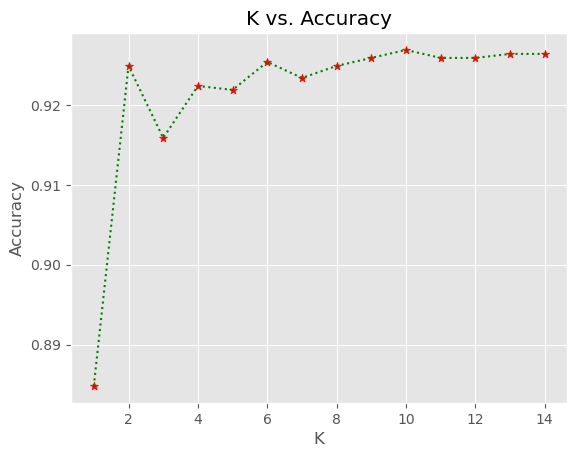

In [139]:
#determine the number, K 
results = []
for k in range(1, 15):
    knn = KNeighborsClassifier(n_neighbors=k).fit(X_train_scaled, y_train)
    results.append({
        'k': k,
        'accuracy': accuracy_score(y_test, knn.predict(X_test_scaled))
    })

# Convert results to a pandas data frame
results = pd.DataFrame(results)
print('accuracy by k')
display(results)
# show accuracy(lift) by k
plt.plot(results.k, results.accuracy, linestyle=':', c='green')
plt.title('K vs. Accuracy')
plt.xlabel('K')
plt.ylabel('Accuracy')

noteworthy_points = results[results['accuracy'] >= .8]
plt.scatter(noteworthy_points.k, noteworthy_points.accuracy, c='red', marker='*')

plt.show()

In [143]:
knn_model = KNeighborsClassifier(
    n_neighbors = 6, #per chart above, 6 has best gain for least complexity.
    weights = 'distance')
knn_model.fit(X_train_scaled, y_train)

#get predictions

knn_predict = knn.predict(X_test_scaled)

#get metrics
a2 = accuracy_score(y_test, knn_predict)
e2 = 1 - a2
r2 = recall_score(y_test, knn_predict)
p2 = precision_score(y_test, knn_predict)
f12 = f1_score(y_test, knn_predict)


#calculate probability for aucroc
knn_proba = knn_model.predict_proba(X_test_scaled)[:, 1]
ra2 =roc_auc_score(y_test, knn_proba)

#get confusion matrix
tn2, fp2, fn2, tp2 = confusion_matrix(y_test, knn_predict).ravel()

#### Model 3: Random Forest

In [145]:
forest_model = RandomForestClassifier(
    n_estimators=200, 
    class_weight='balanced',  # Handle class imbalance
    max_depth=10,  
    min_samples_leaf=5, 
    random_state=42
)

forest_model.fit(X_train_scaled, y_train)

#get predictions
forest_predict = forest_model.predict(X_test_scaled)

#get metrics 

a3 = accuracy_score(y_test, forest_predict)
e3 = 1 - a3
r3 = recall_score(y_test, forest_predict)
p3 = precision_score(y_test, forest_predict)
f13 = f1_score(y_test, forest_predict)

#calculate probability for aucroc
forest_proba = forest_model.predict_proba(X_test_scaled)[:, 1]
ra3 =roc_auc_score(y_test, forest_proba)

#get confusion matrix
tn3, fp3, fn3, tp3 = confusion_matrix(y_test, forest_predict).ravel()

#### Model 4:  SVM

In [147]:
#https://machinelearningmastery.com/cost-sensitive-svm-for-imbalanced-classification/

svm_model = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)

# get predictions
svm_predict = svm_model.predict(X_test_scaled)

#get metrics 
a4 = accuracy_score(y_test, svm_predict)
e4 = 1 - a4
r4 = recall_score(y_test, svm_predict)
p4 = precision_score(y_test, svm_predict)
f14 = f1_score(y_test, svm_predict)

#calculate probability for aucroc
svm_proba = svm_model.predict_proba(X_test_scaled)[:, 1]
ra4 =roc_auc_score(y_test, svm_proba)

#get confusion matrix
tn4, fp4, fn4, tp4 = confusion_matrix(y_test, svm_predict).ravel()

## Question 5:Report the predictive performance of your model in terms of error rates (the confusion matrix). How well does the model perform? Can the model be used in practice?

In [148]:
#create the lists
accuracy = [a1, a2, a3,a4 ]
error_rate = [e1, e2, e3, e4]
recall = [r1, r2, r3, r4]
precision =[p1, p2, p3, p4]
f1 =[f11, f12, f13, f14]
roc_auc = [ra1, ra2, ra3, ra4]
tn =[tn1, tn2, tn3, tn4]
fp = [fp1, fp2, fp3, fp4]
fn = [fn1, fn2, fn3, fn4]
tp = [tp1, tp2, tp3, tp4]
model_compare ={
    'Model': ['Logistic Regression', 'KNN', 'Random Forest', 'SVM'], 
    'Accuracy': accuracy,
    'Error Rate': error_rate,
    'Recall': recall,
    'Precision': precision, 
    'F1 Score': f1, 
    'ROC AUC': roc_auc, 
    'True Negatives': tn, 
    'False Positives': fp,
    'False Negatives': fn, 
    'True Positives': tp
}

model_compare_df = pd.DataFrame(model_compare)

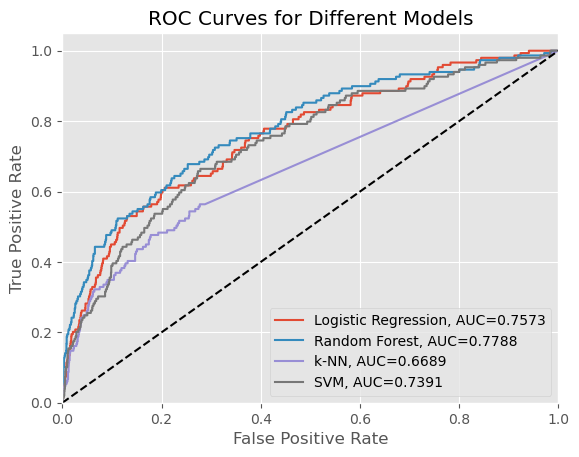

In [149]:
#source : https://www.statology.org/plot-multiple-roc-curves-python/
# Set up the plotting area
plt.figure(0).clf()

# Plot ROC curve for Logistic Regression
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, logreg_proba)
plt.plot(fpr_logreg, tpr_logreg, label=f"Logistic Regression, AUC={ra1:.4f}")

# Plot ROC curve for Random Forest
fpr_forest, tpr_forest, _ = roc_curve(y_test, forest_proba)
plt.plot(fpr_forest, tpr_forest, label=f"Random Forest, AUC={ra3:.4f}")

# Plot ROC curve for k-NN
fpr_knn, tpr_knn, _ = roc_curve(y_test, knn_proba)
plt.plot(fpr_knn, tpr_knn, label=f"k-NN, AUC={ra2:.4f}")

# Plot ROC curve for SVM
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_proba)
plt.plot(fpr_svm, tpr_svm, label=f"SVM, AUC={ra4:.4f}")

# Plot settings
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Models')
plt.legend(loc='lower right')

# Show plot
plt.show()

The graph above shows the ROC AUC performance across models which tells you how well the model distinguishes between classes. The closer to "1" the better a model is performing, and a score of .5 would be the equivalent of random guessing. All of the models are above the .5 threshold, indicating they all perform better than random guessing. Additional metrics can be seen in the table below. Accuracy tells us how good the model is at predicting the correct class, but is misleading when you have class imbalance. Recall  tells us how well the model predicts the positive class. Precision tells you out of the predicted positives, how many were correct. F1 is a balance between Precision and Recall. Thus when evaluating models with class imbalance it is best to prioritize the metrics over accuracy. The following is a discussion of the strengths ans weaknesses of each model: 

- Logistic Regression : highest recall rate (.671) and one of the higher ROC AUC scores (.757) indicating it is good at distinguishing between classes.
- KNN : highest accuracy rate, however the recall is low (.027) indicating that it struggles to predict the minority class - cancellations.
- Random Forest: second place winner for accuracy but has a more balanced scorecard across all other metrics and highest ROC AUC.
- SVM: has a strong recall but a lower F1 score and ROC AUC score than Logistic Regression and Random Forest.

This model can be used in practice. Out of all the models, Random Forest shows shows the most promise with the highest ROC AUC, F1, and balance across metrics. However Logistic Regression is not far behind in terms of ROC AUC and outperforms Random Forest in terms of Recall. 

In [153]:
display(model_compare_df)

,Model,Accuracy,Error Rate,Recall,Precision,F1 Score,ROC AUC,True Negatives,False Positives,False Negatives,True Positives
0,Logistic Regression,0.676,0.324,0.671,0.143,0.236,0.757,1250,598,49,100
1,KNN,0.926,0.074,0.027,0.667,0.052,0.669,1846,2,145,4
2,Random Forest,0.880,0.120,0.450,0.299,0.359,0.779,1691,157,82,67
3,SVM,0.722,0.278,0.644,0.161,0.257,0.739,1346,502,53,96


## Question 6: Examine the predictive performance of your model in terms of ranking (lift). How well does the model perform? Can the model be used in practice?

In [158]:
#source : https://howtolearnmachinelearning.com/code-snippets/lift-curve-code-snippet/

def plot_lift_curve(y_val, y_pred, step=0.01, title="Lift Curve"):
    
    # Define an auxiliary dataframe to plot the curve
    aux_lift = pd.DataFrame()
    # Create a real and predicted column for our new DataFrame and assign values
    aux_lift['real'] = y_val
    aux_lift['predicted'] = y_pred
    # Order the values for the predicted probability column:
    aux_lift.sort_values('predicted', ascending=False, inplace=True)
    
    # Create the values that will go into the X axis of our plot
    x_val = np.arange(step, 1 + step, step)
    # Calculate the ratio of ones in our data
    ratio_ones = aux_lift['real'].sum() / len(aux_lift)
    # Create an empty vector with the values that will go on the Y axis of our plot
    y_v = []
    
    # Calculate for each x value its corresponding y value
    for x in x_val:
        num_data = int(np.ceil(x * len(aux_lift)))  # The ceil function returns the closest integer bigger than our number
        data_here = aux_lift.iloc[:num_data, :]     # Select the data up to the num_data percentile
        ratio_ones_here = data_here['real'].sum() / len(data_here)
        y_v.append(ratio_ones_here / ratio_ones)
           
    # Plot the figure
    fig, axis = plt.subplots()
    fig.figsize = (40, 40)
    axis.plot(x_val, y_v, 'g-', linewidth=3, markersize=5)
    axis.plot(x_val, np.ones(len(x_val)), 'k-')
    axis.set_xlabel('Proportion of sample')
    axis.set_ylabel('Lift')
    axis.set_title(title)  # Set the custom title here
    plt.show()

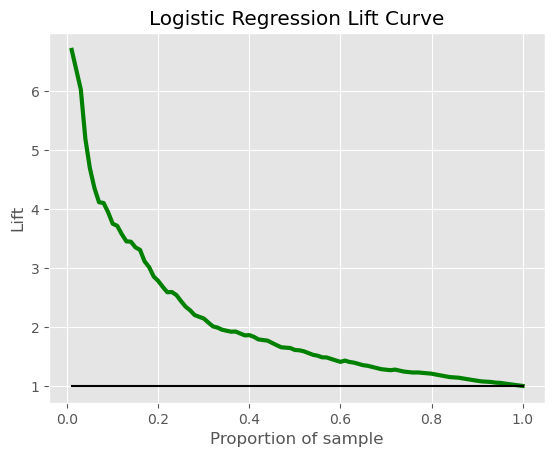

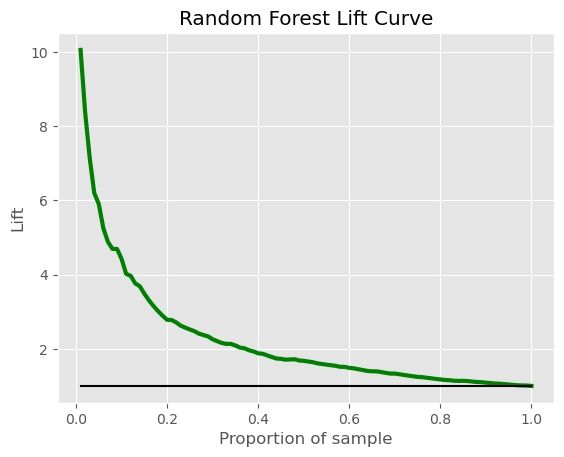

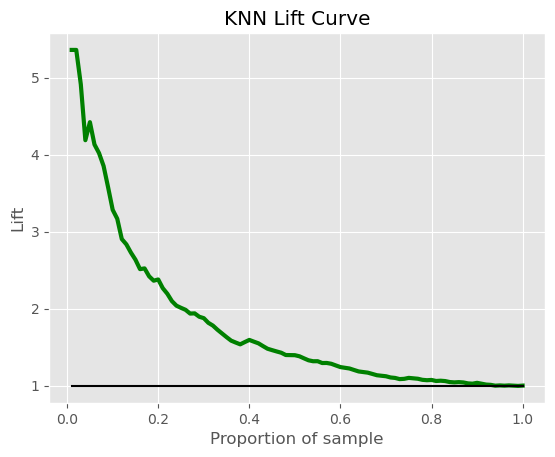

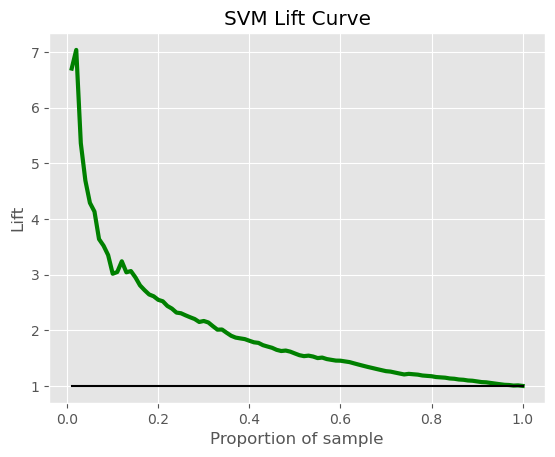

In [160]:
#get lift curves
plot_lift_curve(y_test, logreg_proba, title = "Logistic Regression Lift Curve")
plot_lift_curve(y_test, forest_proba,  title = "Random Forest Lift Curve")
plot_lift_curve(y_test, knn_proba,  title = "KNN Lift Curve")
plot_lift_curve(y_test, svm_proba,  title = "SVM Lift Curve")


The lift curves above are consistent with the AUC ROC scores previously and the model metrics. These lift scores measure how well the models are accurately predicting positives. All of the models perform better than random guessing as they have a lift greater than 1. Random Forest is the best with the highest lift approaching 6. The lift curves reinforce that these models could be used in practice.

## Question 7: Briefly explain, in two to three paragraphs, the business objective, the data mining models used, why they were used, the model results, and your recommendations to your non-technical stakeholder team.

### Business Objective
Yourcabs.com is a taxi company in Bangalore, India. In late 2013, the company experienced a surge in driver cancellations, leading to customer dissatisfaction and, in some cases, being stranded. Additionally in early 2014 Uber launched, increasing competition for Yourcabs.com. The company is seeking to take proactive steps to reduce cancellation rates and retain customers as well ad defend its place in the market. The data science team explored four different predictive models in the attempt to build a model that would be able to predict the likelihood of a cancellation taking place. That way the company can take appropriate action to ensure the customer is able to reach their destination. A sample of 10,000 rides was collected for rides booked between 1/1/13 - 11/24/13. While the company has experienced a surge in driver cancellations, overall the rate of cancelations is low (only 7.4% of the total sample). Consequently, the models that were explored were selected based on their strengths in classifying an imbalanced dataset. 

### Data Mining 
The sample data of 10,000 had many interesting data points that could be used for modeling. We first analyzed how much influence each data point had to the outcome of a cancellation by using a Random Forest decision tree. From this excercise, we were able to isolate the following data points had the most influence: customer ID, vehicle ID, customer pickup location, time between booking and pickup, and when booking occured. These data points were then tested on four different models and compared. Random Forest again, which provides a decision tree of what data points contribute the most to cancellations. KNN which looks across the data and groups it based on being overall the most alike, thus you have an outcome of the "won't cancel" and the "will cancel" groups. Logistic Regression applies statistical formulas and calculates a odds score between 0 (won't cancel) and 1 (will cancel). Lastly, SVM identifies a boundary between what rides will cancel and which won't and uses this boundary to make predictions.  

### Recommendations
With the exception of KNN, all of the models attempted had promising performance and the metrics indicate they are better than randomly guessing. Out of all the models, Random Forest and Logistic Regression were the strongest performers. The data quality of the sample was concerning. Many data points could not be used as there was too much information missing. To improve future modeling, the team recommends: 
- Identify the cause of the missing information
- Work with business team for more robust feature engineering / aka how to split the data we have in more meaningful insights for modeling
- Investigate the selected features for data leakage. For example, are the ID fields (user ID, vehicle ID) truly useful or misleading?